<a href="https://colab.research.google.com/github/amber5252/pytorch_learning/blob/main/Pytorch%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-1

In [3]:
import os
import urllib.request
import zipfile

In [4]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [5]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [6]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

In [7]:
# パッケージのimport
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [8]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121


In [9]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

In [11]:
# 画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/goldenretriever-3724972_640.jpg'

In [ ]:
# ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

# 1-3

In [ ]:
pip install tqdm

In [15]:
#パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#乱数のシード設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [16]:
#入力画像の前処理をするクラス
#訓練時と推論時で処理が異なる

class ImageTransform():
  """
  画像の前処理クラス。訓練時、検証時で異なる動作をする。
  画像のサイズをリサイズ、色を標準化する。
  訓練時はRandomResizedCropsとRandomHorizontalFlipでデータオーグメンテーションする。

  """

  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(
                resize, scale=(0.5,1.0)),#データオーグメンテーション
            transforms.RandomHorizontalFlip(), #データオーグメンテーション
            transforms.ToTensor(),#テンソルへの変換
            transforms.Normalize(mean, std)#標準化
        ]),
        'val': transforms.Compose([
            transforms.Resize(resize),#リサイズ
            transforms.CenterCrop(resize),#画面中央をResize×Resizeで切り取る
            transforms.ToTensor(),#テンソルに変換
            transforms.Normalize(mean, std)#標準化
            ])
    }

  def __call__(self, img, phase='train'):
    """
    Parameters
    ----------
    phase : 'train' or 'val'
        前処理のモードを指定。
    """
    return self.data_transform[phase](img)

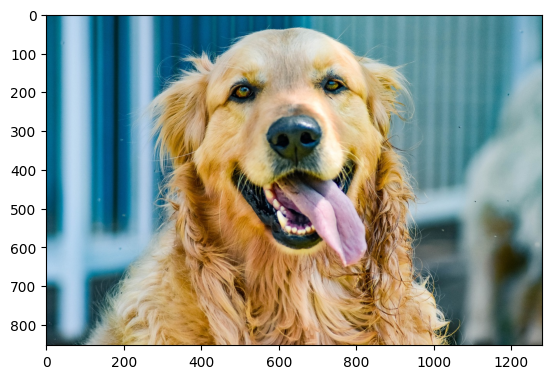

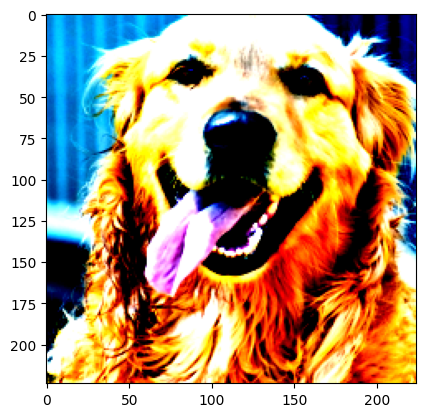

In [17]:
#訓練時の画像前処理の動作を確認
#執行得する度に処理結果の画像が変わる

# 1.画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) #[高さ][幅][色RGB]

# 2.元画像の表示
plt.imshow(img)
plt.show()

# 3.画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train') #torch.size[3,224,224]

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [18]:
# アリとハチの画像へのファイルパスのリストを作成する

def make_tadapath_list(phase='train'):
  """
  データのパスを格納したリストを作成する

  Parameters
  -------
  phase : 'train' or 'val'
    訓練データか検証データかを指定する

  Returns
  -------
  path_list : list
      データへのパスを格納したリスト
  """

  rootpath = "./data/hymenoptera_data/"
  target_path = osp.join(rootpath+phase+'/**/*.jpg')
  print(target_path)

  path_list = [] #空のリストを作成

  #globを利用してサブディレクトリまでファイルパスを取得する
  for path in glob.glob(target_path):
    path_list.append(path)

  return path_list

train_list = make_tadapath_list(phase='train')
val_list = make_tadapath_list(phase='val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2528444139_fa728b0f5b.jpg',
 './data/hymenoptera_data/train/bees/2321139806_d73d899e66.jpg',
 './data/hymenoptera_data/train/bees/2031225713_50ed499635.jpg',
 './data/hymenoptera_data/train/bees/2445215254_51698ff797.jpg',
 './data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg',
 './data/hymenoptera_data/train/bees/95238259_98470c5b10.jpg',
 './data/hymenoptera_data/train/bees/85112639_6e860b0469.jpg',
 './data/hymenoptera_data/train/bees/522104315_5d3cb2758e.jpg',
 './data/hymenoptera_data/train/bees/196430254_46bd129ae7.jpg',
 './data/hymenoptera_data/train/bees/452462677_7be43af8ff.jpg',
 './data/hymenoptera_data/train/bees/2538361678_9da84b77e3.jpg',
 './data/hymenoptera_data/train/bees/2801728106_833798c909.jpg',
 './data/hymenoptera_data/train/bees/1691282715_0addfdf5e8.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/2710368626_cb42882dc8.jpg',
 './data/hymenoptera_data/train/

In [21]:
#アリとハチの画像Datasetを作成する

class HymenopteraDataset(data.Dataset):
  """
  アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承

  Attibute
  -----
  file_list : リスト
    画像のパスを格納したリスト
  transform : object
    前処理クラスのインスタンス
  phase : 'train' or 'val'
    訓練か検証かを指定する変数

  -----
  """
  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list #ファイルパスのリスト
    self.transform = transform #前処理クラス
    self.phase = phase #訓練か検証かを指定

  def __len__(self):
    '''画像の枚数を返す'''
    return len(self.file_list)

  def __getitem__(self, index):
    '''
    前処理をした画像のTensor形式のデータとラベルを取得
    '''

    # index番目の画像をロード
    img_path = self.file_list[index]
    img = Image.open(img_path)

    # 画像の前処理を実施
    img_transformed = self.transform(
        img, self.phase) #torch.Size([3,224,224])

    # 画像のラベルをファイル名から抜き出す
    if self.phase == 'train':
      label = img_path[30:34]
    elif self.phase =="val":
      label = img_path[28:32]

    # ラベルを数値に変更する
    if label == 'ants':
      label = 0
    elif label == 'bees':
      label = 1

    return img_transformed, label

train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

#　動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [22]:
# ミニバッジのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"]) #イテレーターに変換
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)
#

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1])


In [ ]:
# 学習済みのVGG-16モデルをロード